In [76]:
import re

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import dask_geopandas
from collections import OrderedDict

import s3fs
import base64
import json
import os
import requests
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import geopandas as gpd
import netCDF4 as nc
from dotenv import load_dotenv

In [77]:
no2_df = pd.read_parquet(r"Data\NO2\Single_Files\omi_no2_data_2018_01.parquet")

In [78]:
no2_df

,latitude,longitude,ColumnAmountNO2,cloudFraction,LAT1,LAT2,LAT3,LAT4,LON1,LON2,LON3,LON4,date
0,40.261021,-66.970398,2.140970e+15,0.706,39.813400,40.460800,40.688599,40.069599,-67.703598,-66.086601,-66.221298,-67.861298,2018m0101
1,40.371281,-67.037178,2.498735e+15,0.737,39.923100,40.571899,40.799599,40.179100,-67.770897,-66.152100,-66.287300,-67.929199,2018m0101
2,40.481525,-67.104126,2.089319e+15,0.739,40.032799,40.682899,40.910500,40.288601,-67.838501,-66.217903,-66.353500,-67.997101,2018m0101
3,40.591774,-67.171181,1.860055e+15,0.717,40.142200,40.793800,41.021301,40.397999,-67.906303,-66.283798,-66.419899,-68.065498,2018m0101
4,40.701900,-67.238594,2.016183e+15,0.696,40.251801,40.904701,41.132198,40.507401,-67.974197,-66.349998,-66.486603,-68.134102,2018m0101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541837,66.539299,-168.653183,1.938261e+15,1.000,66.474197,66.400597,66.604401,66.666298,-169.608994,-167.684006,-167.692993,-169.632004,2018m0131
541838,66.452316,-166.564926,2.418132e+15,0.000,66.400597,66.285500,66.503197,66.604401,-167.684006,-165.451004,-165.440994,-167.692993,2018m0131
541839,66.658981,-168.662872,1.984927e+15,1.000,66.594101,66.520203,66.723801,66.785896,-169.623001,-167.688995,-167.697998,-169.647003,2018m0131
541840,66.778519,-168.672867,1.569851e+15,1.000,66.713600,66.639503,66.843399,66.905701,-169.638000,-167.694000,-167.703003,-169.660995,2018m0131


In [79]:
maryland = gpd.read_file(r'Data\US_SHAPEFILES\State_Boundary\us-state-boundaries.shp')
maryland = maryland[maryland.name == 'Maryland'][["geometry"]].reset_index(drop=True)

<AxesSubplot: >

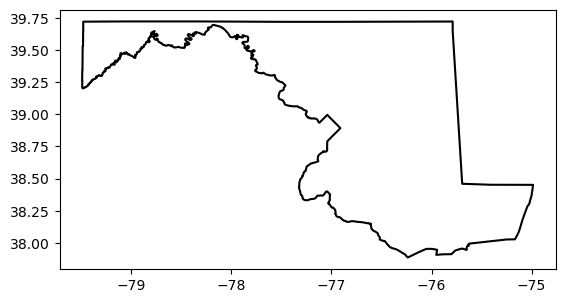

In [80]:
ax = plt.subplot()
maryland.geometry.boundary.plot(ax=ax, color="black")

In [95]:
road = gpd.read_file(r"C:\Users\neupa\Downloads\Maryland_Annual_Average_Daily_Traffic_-_Annual_Average_Daily_Traffic_(SHA_Statewide_AADT_Lines)\Maryland_Annual_Average_Daily_Traffic_-_Annual_Average_Daily_Traffic_(SHA_Statewide_AADT_Lines).shp")
# road = road[road["ID_PREFIX"].isin(["MD", "IS"])]

In [96]:
important_routes = {95, 695, 70, 270, 495, 83, 50, 32, 5, 29}

In [100]:
filtered_df = road[(road["ID_PREFIX"].isin(["IS", "MD"])) & (road["ID_RTE_NO"].astype(int).isin(important_routes))]

<AxesSubplot: >

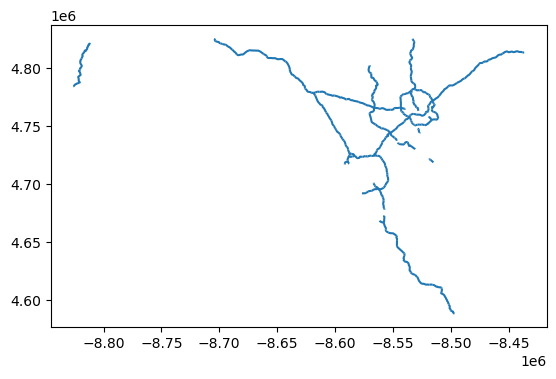

In [101]:
filtered_df.plot()

In [105]:
filtered_df[["ID_PREFIX", "ID_RTE_NO", "Functional Class", "geometry", "AADT2020", "RURAL_URBA"]]

KeyError: "['Functional Class', 'AADT2020'] not in index"

In [86]:
for i in road.columns:
    print(i)

OBJECTID
LOCATION_I
COUNTY_ID
COUNTY_DES
MUN_SORT
MUNICIPALI
ROADNAME
ID_PREFIX
ID_RTE_NO
MP_SUFFIX
ID_MP
BEGIN_SECT
END_SECTIO
STATION_DE
ROAD_SECTI
RURAL_URBA
F_SYSTEM
F_SYSTEM_D
ROUTEID
ROUTEID_RH
MAIN_LINE
PEAK_HOUR_
NUM_LANES
COUNTED_FA
STMP_SEQ
K_FACTOR
D_FACTOR
NORTH_EAST
SOUTH_WEST
AVMT
LINK
AADT_2010
AADT_2011
AADT_2012
AADT_2013
AADT_2014
AADT_2015
AADT_2016
AADT_2017
AADT_2018
AADT
AAWDT_2010
AAWDT_2011
AAWDT_2012
AAWDT_2013
AAWDT_2014
AAWDT_2015
AAWDT_2016
AAWDT_2017
AAWDT_2018
AAWDT
MOTORCYCLE
CAR_AADT
LIGHT_TRUC
BUS_AADT
SINGLE_UNI
COMBINATIO
LOC_ERROR
Shape_Leng
TRUCK_AADT
SUTRUCK_AA
CUTRUCK_AA
MCYCLE_AAD
CAR_AADT_P
LIGHT_TR_1
BUS_AADT_P
SUTRUCK__1
CUTRUCK__1
TRUCK_AA_1
NUM_LANES_
K_FACTOR_A
D_FACTOR_A
NORTH_EA_1
SOUTH_WE_1
AADT_2010_
AADT_2011_
AADT_2012_
AADT_2013_
AADT_2014_
AADT_2015_
AADT_2016_
AADT_2017_
AADT_2018_
AADT_ANNO
AAWDT_20_1
AAWDT_20_2
AAWDT_20_3
AAWDT_20_4
AAWDT_20_5
AAWDT_20_6
AAWDT_20_7
AAWDT_20_8
AAWDT_20_9
AAWDT_ANNO
MOTORCYC_1
CAR_AADT_A
BUS_AADT_A

# OLD

In [23]:
highway_count = pd.read_csv(r"C:\Users\neupa\Downloads\ICC_Vehicle_Volume_Data_20250404.csv")

In [70]:
highway_count.columns

Index(['Date', 'I- 370 - MD 97/ East (I01)', '1-370 - MD 97/ West (I02)',
       'I- 370 - MD 97 Total', 'MD 97 - MD 182/ East  (I05)',
       'MD 97 - MD182/ West (I06)', 'MD 97 - MD 182 Total',
       'MD 182 - MD 650/ East (I07)', 'MD 182- MD 650/ West (I08)',
       'MD 182 - MD 650 Total', 'MD 650 -  US 29/ East (I09)',
       'MD 650 - US 29/ West (I10)', 'MD 650 -  US 29 Total',
       'BC Rd - I -95/ East (I13)', 'BC Rd - I-95/ West (I14)',
       'BC Rd - I -95 Total', 'Konterra Dr/ US 1 (I17)',
       'Konterra DR/ US 1 (I18)', 'Konterra Dr/US 1 Total'],
      dtype='object')

https://opendata.maryland.gov/Transportation/ICC-Vehicle-Volume-Data/8d75-q6az/about_data

In [60]:
roads = gpd.read_file(r"C:\Users\neupa\Downloads\MDOT_SHA_Roadway_National_Highway_System_5309010079320154613\Roadway_National_Highway_System_(NHS).shp")
roads = roads.to_crs("EPSG:4326")
tolls = gpd.read_file(r"C:\Users\neupa\Downloads\Maryland_Toll_Plazas_-_Toll_Plazas\TRAN_TollPlazas_MDTA.shp")
tolls = tolls.to_crs("EPSG:4326")

c:\Users\neupa\anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


In [61]:
icc = roads[(roads["ID_PREFIX"] == "MD") & (roads["ID_RTE_NO"] == 200)]

In [72]:
from shapely.geometry import LineString
segment = LineString([tolls.geometry[2], tolls.geometry[6]])  # I-95 segment
segment_gdf = gpd.GeoDataFrame({"name": ["I-95"], "geometry": [segment]}, crs="EPSG:4326")

<AxesSubplot: >

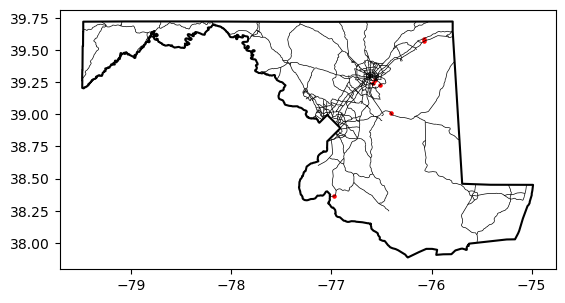

In [74]:
ax = plt.subplot()
roads.plot(ax=ax, linewidth=0.5, color="black")
tolls.plot(ax=ax, color="red", markersize=5)
maryland.geometry.boundary.plot(ax=ax, color="black")

<AxesSubplot: >

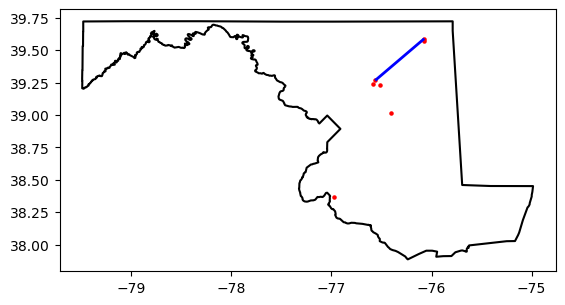

In [75]:
ax = plt.subplot()
# roads.plot(ax=ax, linewidth=0.5, color="black")
tolls.plot(ax=ax, color="red", markersize=5)
maryland.geometry.boundary.plot(ax=ax, color="black")
segment_gdf.plot(ax=ax, color="blue", linewidth=2)

In [69]:
tolls

,OBJECTID,Status,Latitude,Longitude,Name,geometry
0,1,Current,39.568161,-76.073242,Thomas J. Hatem Memorial Bridge (US 40),POINT (-76.07324 39.56815)
1,2,Current,39.229927,-76.510582,Francis Scott Key Bridge (I-695),POINT (-76.51058 39.22992)
2,3,Current,39.266476,-76.562279,Fort McHenry Tunnel (I-95),POINT (-76.56227 39.26647)
3,4,Current,39.241032,-76.587227,Baltimore Harbor Tunnel (I-895),POINT (-76.58723 39.24102)
4,5,Current,39.013069,-76.407379,William Preston Lane Jr. Memorial (Bay) Bridge...,POINT (-76.40738 39.01306)
5,6,Current,38.364449,-76.976036,Governor Harry W. Nice Memorial Bridge (US 301),POINT (-76.97604 38.36444)
6,7,Current,39.588669,-76.072273,John F. Kennedy Memorial Highway (I-95),POINT (-76.07227 39.58866)
